In [1]:
from io import StringIO
import requests
from Bio import SeqIO, Align
import itertools
import numpy as np

# 1️⃣ Daten von PubMLST laden
url = "https://rest.pubmlst.org/db/pubmlst_smaltophilia_seqdef/loci/mutM/alleles_fasta"
response = requests.get(url)
fasta_data = response.text

# Prüfen, ob der Download funktioniert hat
if not fasta_data.startswith(">"):
    raise ValueError("FASTA-Daten ungültig oder nicht heruntergeladen.")

# 2️⃣ Sequenzen einlesen
records = list(SeqIO.parse(StringIO(fasta_data), "fasta"))
print(f"{len(records)} Allele heruntergeladen")

# 3️⃣ SNPs berechnen (Pairwise Alignment)
aligner = Align.PairwiseAligner()
aligner.mode = 'global'
aligner.mismatch_score = -1
aligner.match_score = 1
aligner.open_gap_score = -1
aligner.extend_gap_score = -0.5

def count_snps(seq1, seq2):
    aln = aligner.align(seq1, seq2)[0]
    aln_seq1, aln_seq2 = aln.aligned
    # Wir nehmen nur die einfache Methode: Position für Position vergleichen
    s1 = aln.target
    s2 = aln.query
    snp_count = sum(1 for a, b in zip(s1, s2) if a != b and a != "-" and b != "-")
    return snp_count

# 4️⃣ Beispiel: SNPs zwischen allen Paaren berechnen
n = len(records)
snp_matrix = np.zeros((n, n), dtype=int)

for i, j in itertools.combinations(range(n), 2):
    snps = count_snps(str(records[i].seq), str(records[j].seq))
    snp_matrix[i, j] = snps
    snp_matrix[j, i] = snps

# 5️⃣ Ausgabe
print("SNP-Matrix (Ausschnitt):")
print(snp_matrix[:10, :10])

# Durchschnittliche SNP-Zahl
avg_snps = np.sum(snp_matrix) / (n*(n-1))
print(f"Durchschnittliche SNPs pro Paar: {avg_snps:.2f}")


370 Allele heruntergeladen
SNP-Matrix (Ausschnitt):
[[ 0 28  1  3  4  4  5 14 23 62]
 [28  0 27 27 28 24 26 26 28 70]
 [ 1 27  0  2  3  3  4 13 22 61]
 [ 3 27  2  0  3  3  4 13 22 59]
 [ 4 28  3  3  0  4  5 14 23 62]
 [ 4 24  3  3  4  0  5 10 21 60]
 [ 5 26  4  4  5  5  0 15 22 63]
 [14 26 13 13 14 10 15  0 29 60]
 [23 28 22 22 23 21 22 29  0 68]
 [62 70 61 59 62 60 63 60 68  0]]
Durchschnittliche SNPs pro Paar: 31.65


In [17]:
# GLEICH LANGE GENE!

from io import StringIO
import requests
from Bio import SeqIO
import numpy as np
import itertools

# 1️⃣ Daten von PubMLST laden
url = "https://rest.pubmlst.org/db/pubmlst_smaltophilia_seqdef/loci/mutM/alleles_fasta"
response = requests.get(url)
fasta_data = response.text

if not fasta_data.startswith(">"):
    raise ValueError("FASTA-Daten ungültig oder nicht heruntergeladen.")

# 2️⃣ Sequenzen einlesen
records = list(SeqIO.parse(StringIO(fasta_data), "fasta"))
print(f"{len(records)} Allele heruntergeladen")

# 3️⃣ Alle Sequenzen in ein numpy-Array umwandeln (alle gleich lang!)
seqs = np.array([list(str(rec.seq)) for rec in records])
n = len(seqs)

# 4️⃣ SNPs zählen: positionweise Unterschiede zwischen jedem Paar
snp_matrix = np.zeros((n, n), dtype=int)

for i, j in itertools.combinations(range(n), 2):
    snp_count = np.sum(seqs[i] != seqs[j])
    snp_matrix[i, j] = snp_count
    snp_matrix[j, i] = snp_count

print("SNP-Matrix (Ausschnitt):")
print(snp_matrix[:10, :10])

avg_snps = np.sum(snp_matrix) / (n * (n - 1))
print(f"Durchschnittliche SNPs pro Paar: {avg_snps:.2f}")


370 Allele heruntergeladen
SNP-Matrix (Ausschnitt):
[[ 0 28  1  3  4  4  5 14 23 62]
 [28  0 27 27 28 24 26 26 28 70]
 [ 1 27  0  2  3  3  4 13 22 61]
 [ 3 27  2  0  3  3  4 13 22 59]
 [ 4 28  3  3  0  4  5 14 23 62]
 [ 4 24  3  3  4  0  5 10 21 60]
 [ 5 26  4  4  5  5  0 15 22 63]
 [14 26 13 13 14 10 15  0 29 60]
 [23 28 22 22 23 21 22 29  0 68]
 [62 70 61 59 62 60 63 60 68  0]]
Durchschnittliche SNPs pro Paar: 31.65


Sortierte SNP-Matrix (Ausschnitt):
[[ 0 25 81 81 92 93 94 90 91 92]
 [25  0 76 75 88 89 88 84 86 88]
 [81 76  0 60 91 91 89 88 88 90]
 [81 75 60  0 79 79 77 76 76 78]
 [92 88 91 79  0  6  7  8  3  5]
 [93 89 91 79  6  0  7 10  5  5]
 [94 88 89 77  7  7  0  9  6  6]
 [90 84 88 76  8 10  9  0  7  7]
 [91 86 88 76  3  5  6  7  0  4]
 [92 88 90 78  5  5  6  7  4  0]]


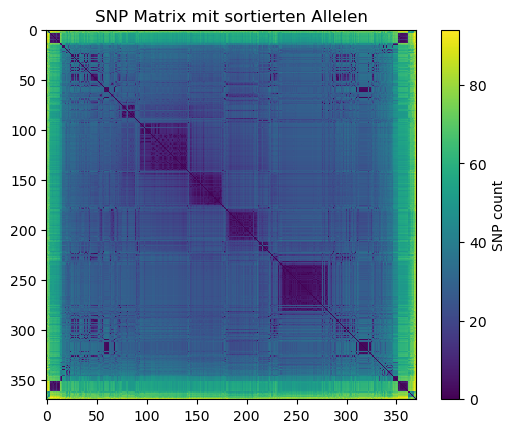

In [18]:
from sklearn.manifold import MDS
import numpy as np

# Annahme: snp_matrix ist symmetrisch und hat 0 auf der Diagonalen

# 1. MDS mit 1 Dimension (um Reihenfolge zu erhalten)
mds = MDS(n_components=1, dissimilarity='precomputed')
embedding = mds.fit_transform(snp_matrix)

# 2. Reihenfolge nach eingebetteten Werten
order = np.argsort(embedding[:, 0])

# 3. Matrix entsprechend umsortieren (Zeilen & Spalten)
snp_matrix_sorted = snp_matrix[np.ix_(order, order)]

# 4. Ergebnis anzeigen
print("Sortierte SNP-Matrix (Ausschnitt):")
print(snp_matrix_sorted[:10, :10])

import matplotlib.pyplot as plt

plt.imshow(snp_matrix_sorted, cmap='viridis')
plt.colorbar(label='SNP count')
plt.title('SNP Matrix mit sortierten Allelen')
plt.show()

C:\Users\uhewm\AppData\Local\Temp\ipykernel_22268\1771979.py:6: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(snp_matrix, method='average')


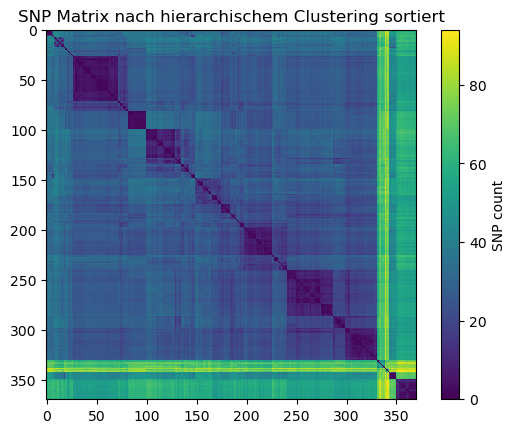

In [19]:
from scipy.cluster.hierarchy import linkage, leaves_list
import numpy as np
import matplotlib.pyplot as plt

# 1. Linkage-Matrix mit SNPs als Distanz (kann z.B. 'average' Methode sein)
Z = linkage(snp_matrix, method='average')

# 2. Reihenfolge aus dem Dendrogramm holen (Leaves order)
order = leaves_list(Z)

# 3. Matrix neu sortieren
snp_matrix_sorted = snp_matrix[np.ix_(order, order)]

# 4. Plot
plt.imshow(snp_matrix_sorted, cmap='viridis')
plt.colorbar(label='SNP count')
plt.title('SNP Matrix nach hierarchischem Clustering sortiert')
plt.show()
